### Importing essentials

In [ ]:
import numpy as np
import pandas as pd
from edazer import interactive_df
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import joblib


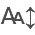

In [2]:
interactive_df(True)

In [3]:
logs_df = pd.read_csv("./dataset/synthetic_logs.csv")
logs_df

timestamp           source  \
0     2025-06-27 07:20:25        ModernCRM   
1         1/14/2025 23:07        ModernCRM   
2          1/17/2025 1:29  AnalyticsEngine   
3     2025-07-12 00:24:16         ModernHR   
4     2025-06-02 18:25:23    BillingSystem   
...                   ...              ...   
2405  2025-08-13 07:29:25         ModernHR   
2406       1/11/2025 5:32         ModernHR   
2407  2025-08-03 03:07:47    ThirdPartyAPI   
2408     11/11/2025 11:52    BillingSystem   
2409     12/25/2025 13:21  AnalyticsEngine   

                                            log_message    target_label  
0     nova.osapi_compute.wsgi.server [req-b9718cd8-f...     HTTP Status  
1        Email service experiencing issues with sending  Critical Error  
2             Unauthorized access to data was attempted  Security Alert  
3     nova.osapi_compute.wsgi.server [req-4895c258-b...     HTTP Status  
4     nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...     HTTP Status  
...                                                 ...             ...  
2405  nova.osapi_compute.wsgi.server [req-96c3ec98-2...     HTTP Status  
2406  User 3844 account experienced multiple failed ...  Security Alert  
2407  nova.metadata.wsgi.server [req-b6d4a270-accb-4...     HTTP Status  
2408      Email service affected by failed transmission  Critical Error  
2409  Repeated failed login attempts occurred for us...  Security Alert  

[2410 rows x 4 columns]

In [4]:
logs_df["source"].unique()

array(['ModernCRM', 'AnalyticsEngine', 'ModernHR', 'BillingSystem',
       'ThirdPartyAPI', 'LegacyCRM'], dtype=object)


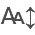

In [5]:
interactive_df(activate=False)

### Embeddings creation

In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [7]:
embeddings = model.encode(logs_df["log_message"])
embeddings

/home/adarsh_r/VScode/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


array([[-0.1029396 ,  0.03354595, -0.02202608, ...,  0.00457793,
        -0.04259716,  0.00322623],
       [ 0.00804573, -0.03573924,  0.04938739, ...,  0.01538321,
        -0.06230951, -0.02774664],
       [-0.00908221,  0.13003927, -0.05275569, ...,  0.02014104,
        -0.05117096, -0.02930295],
       ...,
       [-0.04022269,  0.0422436 , -0.06610421, ...,  0.02363671,
        -0.00530876,  0.02044457],
       [-0.0360345 ,  0.01960898,  0.10052753, ...,  0.03668106,
        -0.02487853, -0.00578848],
       [ 0.01457432,  0.0491183 , -0.00301354, ...,  0.01029743,
        -0.00068495,  0.0070886 ]], dtype=float32)

In [8]:
embeddings.shape

(2410, 384)

### Clustering similar log messages

In [9]:
dbscan = DBSCAN(eps=0.3, min_samples=3)
cluster_labels = dbscan.fit_predict(embeddings)

In [10]:
unique_cluster_labels = np.unique(cluster_labels)
unique_cluster_labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [11]:
logs_df["cluster_labels"] = cluster_labels

cluster label =2 -> Backup completed successfully.\
cluster label =6 -> Backup started at 2025-02-03 22:33:16.\
cluster label =8 -> System reboot initiated by user User766.\
cluster label =2 -> Backup completed successfully.\
cluster label =13 -> Disk cleanup completed successfully.\
cluster label =14 -> Backup ended at 2025-08-08 13:06:23.\
cluster label =16 -> Critical system element is down: element ID Co... #need to \
cluster label =16 -> System reboot initiated by user User938.\
cluster label =22 ->  Essential system part malfunction: part ID Com...\
cluster label =25 -> System updated to version 3.7.7.\
cluster label =26 -> User User881 logged out.\
cluster label =28 -> Vital system component is down: component ID C...\
cluster label =29 -> System updated to version 5.0.7.\
cluster label =30 -> Critical system equipment failure: equipment I...\
cluster label =40 -> File data_7366.csv uploaded successfully by us...\
cluster label =45 ->Anomalous traffic from 192.168.208.255 flagged...\
cluster label =48 -> Key system element crashed: element ID Compone...

In [12]:
def show_clutered_logs(cluster_label):
    query= f"""
    SELECT log_message FROM logs_df
    WHERE cluster_labels ={cluster_label}
    """
    clustered_logs_df =logs_df[logs_df["cluster_labels"] == cluster_label]
    target_label = clustered_logs_df["target_label"].unique()[0]
    
    print(f"cluster no: {cluster_label}")
    print(f"target label: {target_label}")
    print(clustered_logs_df["log_message"])
    print("-"*50 + "\n\n")

In [13]:
for cluster_label in cluster_labels:
    show_clutered_logs(cluster_label)

cluster no: 0
target label: HTTP Status
0       nova.osapi_compute.wsgi.server [req-b9718cd8-f...
3       nova.osapi_compute.wsgi.server [req-4895c258-b...
4       nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...
5       nova.osapi_compute.wsgi.server [req-f0bffbc3-5...
9       nova.osapi_compute.wsgi.server [req-2bf7cfee-a...
                              ...                        
2389    nova.osapi_compute.wsgi.server [req-410ed8a3-3...
2391    nova.osapi_compute.wsgi.server [req-bb798c56-0...
2401    nova.osapi_compute.wsgi.server [req-4bdf00b0-3...
2404    nova.osapi_compute.wsgi.server [req-2c9c783f-3...
2405    nova.osapi_compute.wsgi.server [req-96c3ec98-2...
Name: log_message, Length: 755, dtype: object
--------------------------------------------------


cluster no: -1
target label: Critical Error
1          Email service experiencing issues with sending
2               Unauthorized access to data was attempted
6               Shard 6 replication task ended in failure
7    

In [14]:
logs_df

timestamp           source  \
0     2025-06-27 07:20:25        ModernCRM   
1         1/14/2025 23:07        ModernCRM   
2          1/17/2025 1:29  AnalyticsEngine   
3     2025-07-12 00:24:16         ModernHR   
4     2025-06-02 18:25:23    BillingSystem   
...                   ...              ...   
2405  2025-08-13 07:29:25         ModernHR   
2406       1/11/2025 5:32         ModernHR   
2407  2025-08-03 03:07:47    ThirdPartyAPI   
2408     11/11/2025 11:52    BillingSystem   
2409     12/25/2025 13:21  AnalyticsEngine   

                                            log_message    target_label  \
0     nova.osapi_compute.wsgi.server [req-b9718cd8-f...     HTTP Status   
1        Email service experiencing issues with sending  Critical Error   
2             Unauthorized access to data was attempted  Security Alert   
3     nova.osapi_compute.wsgi.server [req-4895c258-b...     HTTP Status   
4     nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...     HTTP Status   
...                                                 ...             ...   
2405  nova.osapi_compute.wsgi.server [req-96c3ec98-2...     HTTP Status   
2406  User 3844 account experienced multiple failed ...  Security Alert   
2407  nova.metadata.wsgi.server [req-b6d4a270-accb-4...     HTTP Status   
2408      Email service affected by failed transmission  Critical Error   
2409  Repeated failed login attempts occurred for us...  Security Alert   

      cluster_labels  
0                  0  
1                 -1  
2                 -1  
3                  0  
4                  0  
...              ...  
2405               0  
2406              -1  
2407               7  
2408              -1  
2409              -1  

[2410 rows x 5 columns]

#### "nova" inspection

In [15]:
logs_df[logs_df["log_message"].str.startswith("nova")]["target_label"].value_counts()

target_label
HTTP Status       1017
Resource Usage     177
Name: count, dtype: int64

In [16]:
logs_df["target_label"].value_counts()

target_label
HTTP Status            1017
Security Alert          371
System Notification     356
Error                   177
Resource Usage          177
Critical Error          161
User Action             144
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64

In [17]:
df_with_only_nova = logs_df[logs_df["log_message"].str.startswith("nova")]
df_with_only_nova

timestamp         source  \
0     2025-06-27 07:20:25      ModernCRM   
3     2025-07-12 00:24:16       ModernHR   
4     2025-06-02 18:25:23  BillingSystem   
5     2025-10-09 10:30:31       ModernHR   
8     2025-02-12 10:42:29  ThirdPartyAPI   
...                   ...            ...   
2400  2025-01-07 09:13:28  ThirdPartyAPI   
2401  2025-12-05 15:51:51      ModernCRM   
2404  2025-09-18 02:18:30  ThirdPartyAPI   
2405  2025-08-13 07:29:25       ModernHR   
2407  2025-08-03 03:07:47  ThirdPartyAPI   

                                            log_message    target_label  \
0     nova.osapi_compute.wsgi.server [req-b9718cd8-f...     HTTP Status   
3     nova.osapi_compute.wsgi.server [req-4895c258-b...     HTTP Status   
4     nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...     HTTP Status   
5     nova.osapi_compute.wsgi.server [req-f0bffbc3-5...     HTTP Status   
8     nova.compute.claims [req-a07ac654-8e81-416d-bf...  Resource Usage   
...                                                 ...             ...   
2400  nova.compute.resource_tracker [req-addc1839-2e...  Resource Usage   
2401  nova.osapi_compute.wsgi.server [req-4bdf00b0-3...     HTTP Status   
2404  nova.osapi_compute.wsgi.server [req-2c9c783f-3...     HTTP Status   
2405  nova.osapi_compute.wsgi.server [req-96c3ec98-2...     HTTP Status   
2407  nova.metadata.wsgi.server [req-b6d4a270-accb-4...     HTTP Status   

      cluster_labels  
0                  0  
3                  0  
4                  0  
5                  0  
8                  1  
...              ...  
2400              17  
2401               0  
2404               0  
2405               0  
2407               7  

[1194 rows x 5 columns]

In [18]:
df_with_only_nova["log_message"].apply(lambda msg: "HTTP" in str(msg)).value_counts()

log_message
True     1017
False     177
Name: count, dtype: int64

In [19]:
df_with_only_nova["log_message"].apply(lambda msg: "HTTP status code" in str(msg)).value_counts()

log_message
False    990
True     204
Name: count, dtype: int64

In [20]:
logs_df["log_message"].apply(lambda msg: "HTTP" in str(msg)).value_counts()

log_message
False    1393
True     1017
Name: count, dtype: int64

- this shows that all the log messages containing "HTTP" (begins with "nova")in them maps to "HTTP Status" in target label
- log messages beginning with nova has either "HTTP Status Code" or "Resource Usage" in target label


### Regex

cluster label =2 -> Backup completed successfully.\
cluster label =6 -> Backup started at 2025-02-03 22:33:16.\
cluster label =8 -> System reboot initiated by user User766.\
cluster label =2 -> Backup completed successfully.\
cluster label =13 -> Disk cleanup completed successfully.\
cluster label =14 -> Backup ended at 2025-08-08 13:06:23.\
cluster label =16 -> Critical system element is down: element ID Co... #need to \
cluster label =16 -> System reboot initiated by user User938.\
cluster label =22 ->  Essential system part malfunction: part ID Com...\
cluster label =25 -> System updated to version 3.7.7.\
cluster label =26 -> User User881 logged out.\
cluster label =28 -> Vital system component is down: component ID C...\
cluster label =29 -> System updated to version 5.0.7.\
cluster label =30 -> Critical system equipment failure: equipment I...\
cluster label =40 -> File data_7366.csv uploaded successfully by us...\
cluster label =45 ->Anomalous traffic from 192.168.208.255 flagged...\
cluster label =48 -> Key system element crashed: element ID Compone...

In [21]:
for cluster_label in cluster_labels:
    show_clutered_logs(cluster_label)

cluster no: 0
target label: HTTP Status
0       nova.osapi_compute.wsgi.server [req-b9718cd8-f...
3       nova.osapi_compute.wsgi.server [req-4895c258-b...
4       nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...
5       nova.osapi_compute.wsgi.server [req-f0bffbc3-5...
9       nova.osapi_compute.wsgi.server [req-2bf7cfee-a...
                              ...                        
2389    nova.osapi_compute.wsgi.server [req-410ed8a3-3...
2391    nova.osapi_compute.wsgi.server [req-bb798c56-0...
2401    nova.osapi_compute.wsgi.server [req-4bdf00b0-3...
2404    nova.osapi_compute.wsgi.server [req-2c9c783f-3...
2405    nova.osapi_compute.wsgi.server [req-96c3ec98-2...
Name: log_message, Length: 755, dtype: object
--------------------------------------------------


cluster no: -1
target label: Critical Error
1          Email service experiencing issues with sending
2               Unauthorized access to data was attempted
6               Shard 6 replication task ended in failure
7    

In [22]:
def logs_msg_that_contains(msg):
    return logs_df[logs_df["log_message"].str.contains(msg)]
logs_msg_that_contains("Data replication")["target_label"].unique()

array(['Error'], dtype=object)

In [23]:
patterns = {
    "Backup completed successfully." : "System Notification",
    "Backup started at .+" : "System Notification",
    "System reboot initiated by user User.+" :  "System Notification",
    "Disk cleanup completed successfully." : "System Notification",
    "Backup ended at .+" : "System Notification",
    "HTTP": "HTTP Status",
    "Essential system part malfunction:" : "Critical Error",
    "System updated to version": "System Notification",
    "User User.+ logged out.": "User Action",
    "User User.+ logged in." : "User Action",
    "System updated to version" : "System Notification",
    "Critical system equipment failure:": "Critical Error",
    "File data_.+.csv uploaded successfully": "System Notification",
    "Anomalous traffic from" : "Security Alert",
    "Key system element crashed:" : "Critical Error",
    "Critical system element is down" : "Critical Error",
    "Vital system component is down" : "Critical Error",
    "Data replication" : "Error"
}


In [24]:
def classify_with_regex(log_msg):
    for pattern in patterns:
        if re.search(pattern, log_msg):
            return patterns[pattern]
        if "nova" in log_msg and "HTTP" not in log_msg:
            return "Resource Usage"

logs_df["regex_label"] = logs_df["log_message"].apply(classify_with_regex)

In [25]:
logs_df["regex_label"].value_counts()

regex_label
HTTP Status            1017
System Notification     356
Resource Usage          177
User Action             100
Error                    15
Critical Error           15
Security Alert            3
Name: count, dtype: int64

In [26]:
logs_df[logs_df["regex_label"].isnull()]["cluster_labels"].value_counts()

cluster_labels
-1     715
 32      9
 47      3
Name: count, dtype: int64

### next

In [27]:
logs_df_non_regex = logs_df[logs_df["regex_label"].isnull()]
logs_df_non_regex

timestamp           source  \
1      1/14/2025 23:07        ModernCRM   
2       1/17/2025 1:29  AnalyticsEngine   
6       3/1/2025 19:14         ModernHR   
10      8/9/2025 18:58        ModernCRM   
11     6/15/2025 11:44         ModernHR   
...                ...              ...   
2398    3/31/2025 4:11         ModernHR   
2402    3/13/2025 9:44    BillingSystem   
2406    1/11/2025 5:32         ModernHR   
2408  11/11/2025 11:52    BillingSystem   
2409  12/25/2025 13:21  AnalyticsEngine   

                                            log_message    target_label  \
1        Email service experiencing issues with sending  Critical Error   
2             Unauthorized access to data was attempted  Security Alert   
6             Shard 6 replication task ended in failure           Error   
10             Email server encountered a sending fault           Error   
11      Critical system unit error: unit ID Component55  Critical Error   
...                                                 ...             ...   
2398  Potential vulnerability exploit detected from ...  Security Alert   
2402            Replication error occurred for shard 10           Error   
2406  User 3844 account experienced multiple failed ...  Security Alert   
2408      Email service affected by failed transmission  Critical Error   
2409  Repeated failed login attempts occurred for us...  Security Alert   

      cluster_labels regex_label  
1                 -1        None  
2                 -1        None  
6                 -1        None  
10                -1        None  
11                -1        None  
...              ...         ...  
2398              -1        None  
2402              -1        None  
2406              -1        None  
2408              -1        None  
2409              -1        None  

[727 rows x 6 columns]

In [28]:
logs_df_non_regex_bert = logs_df_non_regex[logs_df_non_regex["source"] != "LegacyCRM"]

In [29]:
logs_df_non_regex_bert["target_label"].value_counts()

target_label
Security Alert    368
Error             162
Critical Error    146
User Action        44
Name: count, dtype: int64

In [30]:
sbert_embeddings = embeddings[logs_df_non_regex_bert.index, :]
sbert_embeddings.shape

(720, 384)

In [31]:
svc = SVC(probability=True, random_state=42).fit(sbert_embeddings[:600], logs_df_non_regex_bert["target_label"].iloc[:600])

In [32]:
cross_val_score(svc, sbert_embeddings, logs_df_non_regex_bert["target_label"], cv=5, scoring="accuracy")

array([0.97916667, 0.98611111, 0.99305556, 1.        , 0.99305556])

In [33]:
preds = svc.predict(sbert_embeddings[600:])
print(classification_report(logs_df_non_regex_bert["target_label"].iloc[600:], preds))

                precision    recall  f1-score   support

Critical Error       1.00      0.95      0.98        22
         Error       1.00      1.00      1.00        26
Security Alert       0.99      1.00      0.99        69
   User Action       1.00      1.00      1.00         3

      accuracy                           0.99       120
     macro avg       1.00      0.99      0.99       120
  weighted avg       0.99      0.99      0.99       120



**if the prediction are made with less confidence, we pass it to llm**

In [39]:
pred_prob = svc.predict_proba(sbert_embeddings)
pd.DataFrame(pred_prob)*100

0          1          2         3
0     4.236621  95.343695   0.189083  0.230601
1     0.064171   0.150757  99.720667  0.064404
2     0.944855  98.328219   0.497709  0.229217
3     0.899681  98.640190   0.245645  0.214484
4    98.833398   0.476650   0.407264  0.282688
..         ...        ...        ...       ...
715   0.471832   0.227637  99.199743  0.100787
716   0.933233  98.116126   0.677728  0.272913
717   0.166408   0.242180  99.234915  0.356497
718  97.299043   1.683403   0.678375  0.339180
719   0.212175   0.126142  99.470317  0.191367

[720 rows x 4 columns]

In [43]:
svc.predict_proba([sbert_embeddings[0, :]])

array([[0.04236621, 0.95343695, 0.00189083, 0.00230601]])

In [56]:
x = model.encode("hello").reshape(1, -1)
svc.predict_proba(x)


array([[0.26937021, 0.22807797, 0.48429803, 0.01825379]])

In [51]:
joblib.dump(svc, "svc.joblib")

['svc.joblib']